The following project is about taking data from the Bungie API to at least partially examine the theory that players in the destiny community will continue to use or not use weapons, regardless of the strength of the buff/nerf (positive or negative stat changes). The below code pulls information from the Bungie API to get the previous n matches a player has played, get all of the players from that match (excluding previously seen players) and then repeat the same process "iterationsMax" times. This gets us a recursive method that scales outwards from an arbitrary starting point to get a very big list of games to then look at all of the weapons that were used in that match and assemble them into a DF. We then perform various filtering on that dataframe to see what the most used options are in different lights. As with any project, there are more things I wish I would have done differently, and I would be happy to elaborate on those further orally, but they are also documented at the end of the presentation. Also, the graph in the presentation is different than the one that will generate from running this code, because I tweaked the "gamesCount" and "iterationsMax" to favor runtime for rapid testing. The results are still valid though and demonstrate data filtering that SHOULD have been done by Tuesday, but ran into some stupid errors >:( Thank you for a fantastic semester Ms.Suarez, I had a fantastic time working on this project.

In [2]:
import requests as rq
import pandas as pd
import matplotlib.pyplot as plt
import json

HEADERS = {"X-API-Key":"b6c157d4681b4243894630269e9f9700"}

# makes dataframes nicer to read
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


personalMembershipID = 4611686018434543311
personalWarlockID = 2305843009292406567
gamesCount = 25
iterationsMax = 2
startingPGCR = 10689963777
pgcrInstanceList = []
p = {"accountId":[personalMembershipID], "characterId":[personalWarlockID]}
playerDF = pd.DataFrame(data=p)
weaponDF = pd.DataFrame(columns=["date"])
currentDate = ""
count = 0
mode = 10 #control https://bungie-net.github.io/multi/schema_Destiny-HistoricalStats-Definitions-DestinyActivityModeType.html#schema_Destiny-HistoricalStats-Definitions-DestinyActivityModeType


def getPlayerMatches(accountID): #get a list of "gamesCount" games that the player has played. Going to be slapped into a DF later
    charID = getCharacterID(accountID=accountID)
    query = "https://www.bungie.net/Platform/Destiny2/-1/Account/" + str(accountID) + "/Character/" + str(charID) + "/Stats/Activities/?count=" + str(gamesCount) + "&mode=" + str(mode) + "&page=0"
    history = rq.get(query, headers=HEADERS)
    historyDF = pd.DataFrame.from_dict(history.json()["Response"]["activities"], orient="columns")
    return historyDF

def getPlayerMatches2(accountID, characterID):
    query = "https://www.bungie.net/Platform/Destiny2/-1/Account/" + str(accountID) + "/Character/" + str(characterID) + "/Stats/Activities/?count=" + str(gamesCount) + "&mode=" + str(mode) + "&page=0"
    history = rq.get(query, headers=HEADERS)
    if(history.json()["ErrorCode"] == 1):
        historyDF = pd.DataFrame.from_dict(history.json()["Response"]["activities"], orient="columns")
    return historyDF

def getPlayerAccounts(initialPGCR, iterator):
    global playerDF
    global weaponDF
    global currentDate
    global count
    playerList = []
    # iterator += 1
    skip = False
    pgcr = rq.get("https://www.bungie.net/Platform/Destiny2/Stats/PostGameCarnageReport/" + str(initialPGCR), headers=HEADERS)
    pgcrDF = pd.DataFrame.from_dict(pgcr.json()["Response"], orient="index").T
    pgcrDF = pgcrDF[["period","entries"]]
    currentDate = str(pgcrDF.iat[0,0])[:10]
    if len(pgcrDF["entries"][0]) <= 12:
        for i in range(len(pgcrDF["entries"][0])):
            try:
                if initialPGCR in pgcrInstanceList:
                    continue
                for u in range(len(pgcrDF["entries"][0][i]["extended"]["weapons"])):
                    count += 1
                    weaponId = pgcrDF["entries"][0][i]["extended"]["weapons"][u]["referenceId"]
                    weaponKills = pgcrDF["entries"][0][i]["extended"]["weapons"][u]["values"]["uniqueWeaponKills"]["basic"]["value"]
                    append2 = pd.DataFrame({"date":[currentDate], str(weaponId):[weaponKills]})
                    weaponDF = pd.concat([weaponDF, append2], ignore_index=True)
            except:
                pass
            accountId = pgcrDF["entries"][0][i]["player"]["destinyUserInfo"]["membershipId"]
            playerList.append(accountId)
            char = getCharacterID(accountID=accountId)
            info = {"accountId":[accountId], "characterId":[char]}
            df = pd.DataFrame(data=info)
            playerDF = pd.concat([playerDF, df], ignore_index=True)
        pgcrInstanceList.append(initialPGCR)
        for j in range(len(playerList)):
            iterPlayer = playerList[j]
            iterQuery = rq.get("https://www.bungie.net/Platform/Destiny2/-1/Account/" + str(iterPlayer) + "/Character/" + str(getCharacterID(iterPlayer)) + "/Stats/Activities/?count=" + str(1) + "&mode=" + str(mode) + "&page=0", headers=HEADERS)
            if(iterQuery.json()["ErrorCode"] == 1):
                if len(iterQuery.json()["Response"]) > 0:
                    if len(iterQuery.json()["Response"]["activities"]) > 0:
                        iterInstance = iterQuery.json()["Response"]["activities"][0]["activityDetails"]["instanceId"]
                        if ((iterator < iterationsMax) and not(skip)):
                            getPlayerAccounts(iterInstance, iterator=iterator+1)
        



def getCharacterID(accountID): #gets the character that the account has the most time on
    query = ""
    for i in range(5):
        query = "https://www.bungie.net/Platform/Destiny2/" + str(i+1) + "/Profile/" + str(accountID) + "/?components=Profiles,Characters"
        request = rq.get(query, headers=HEADERS)
        if(request.json()["ErrorCode"] == 1):
            ids = request.json()["Response"]["profile"]["data"]["characterIds"]
            # print(ids)
            maxTime = 0
            maxTimeID = 0
            for id in ids:
                if int(request.json()["Response"]["characters"]["data"][str(id)]["minutesPlayedTotal"]) > int(maxTime):
                    maxTime = request.json()["Response"]["characters"]["data"][str(id)]["minutesPlayedTotal"]
                    maxTimeID = id
            return maxTimeID

manifest = rq.get("https://www.bungie.net/Platform/Destiny2/Manifest", headers=HEADERS)

getPlayerAccounts(startingPGCR, 0)

weaponDF.fillna(0, inplace=True)

KeyboardInterrupt: 

In [ ]:
# #processing done after getting the list, meaning that we dont have to wait for the long runtime to get other information
import numpy as np
weaponNamesDF = weaponDF
for col in weaponNamesDF:
    if col != "date":
        hashInfo = rq.get("https://www.bungie.net/Platform/Destiny2/Manifest/DestinyInventoryItemDefinition/"+str(col), headers=HEADERS)
        itemName = hashInfo.json()["Response"]["displayProperties"]["name"]
        weaponNamesDF = weaponNamesDF.rename(columns={str(col):itemName})

Assembles the now named dataframe of weapons into the total number of kills per day. Maintains the same number of columns, but no longer has duplicate rows.

In [ ]:
weaponNamesDFKills = weaponNamesDF.groupby(["date"]).sum()

Graphs all of the data captured after removing duplicate dates. Very hard to interpret, but still fun to see all of the information laid out. (All of the dips to zero mean that among the players tracked, no-one got a kill on that day. This is NOT the same as that weapon being not used that day, it just means that none of the players in their most recent matches used that weapon.)

[]

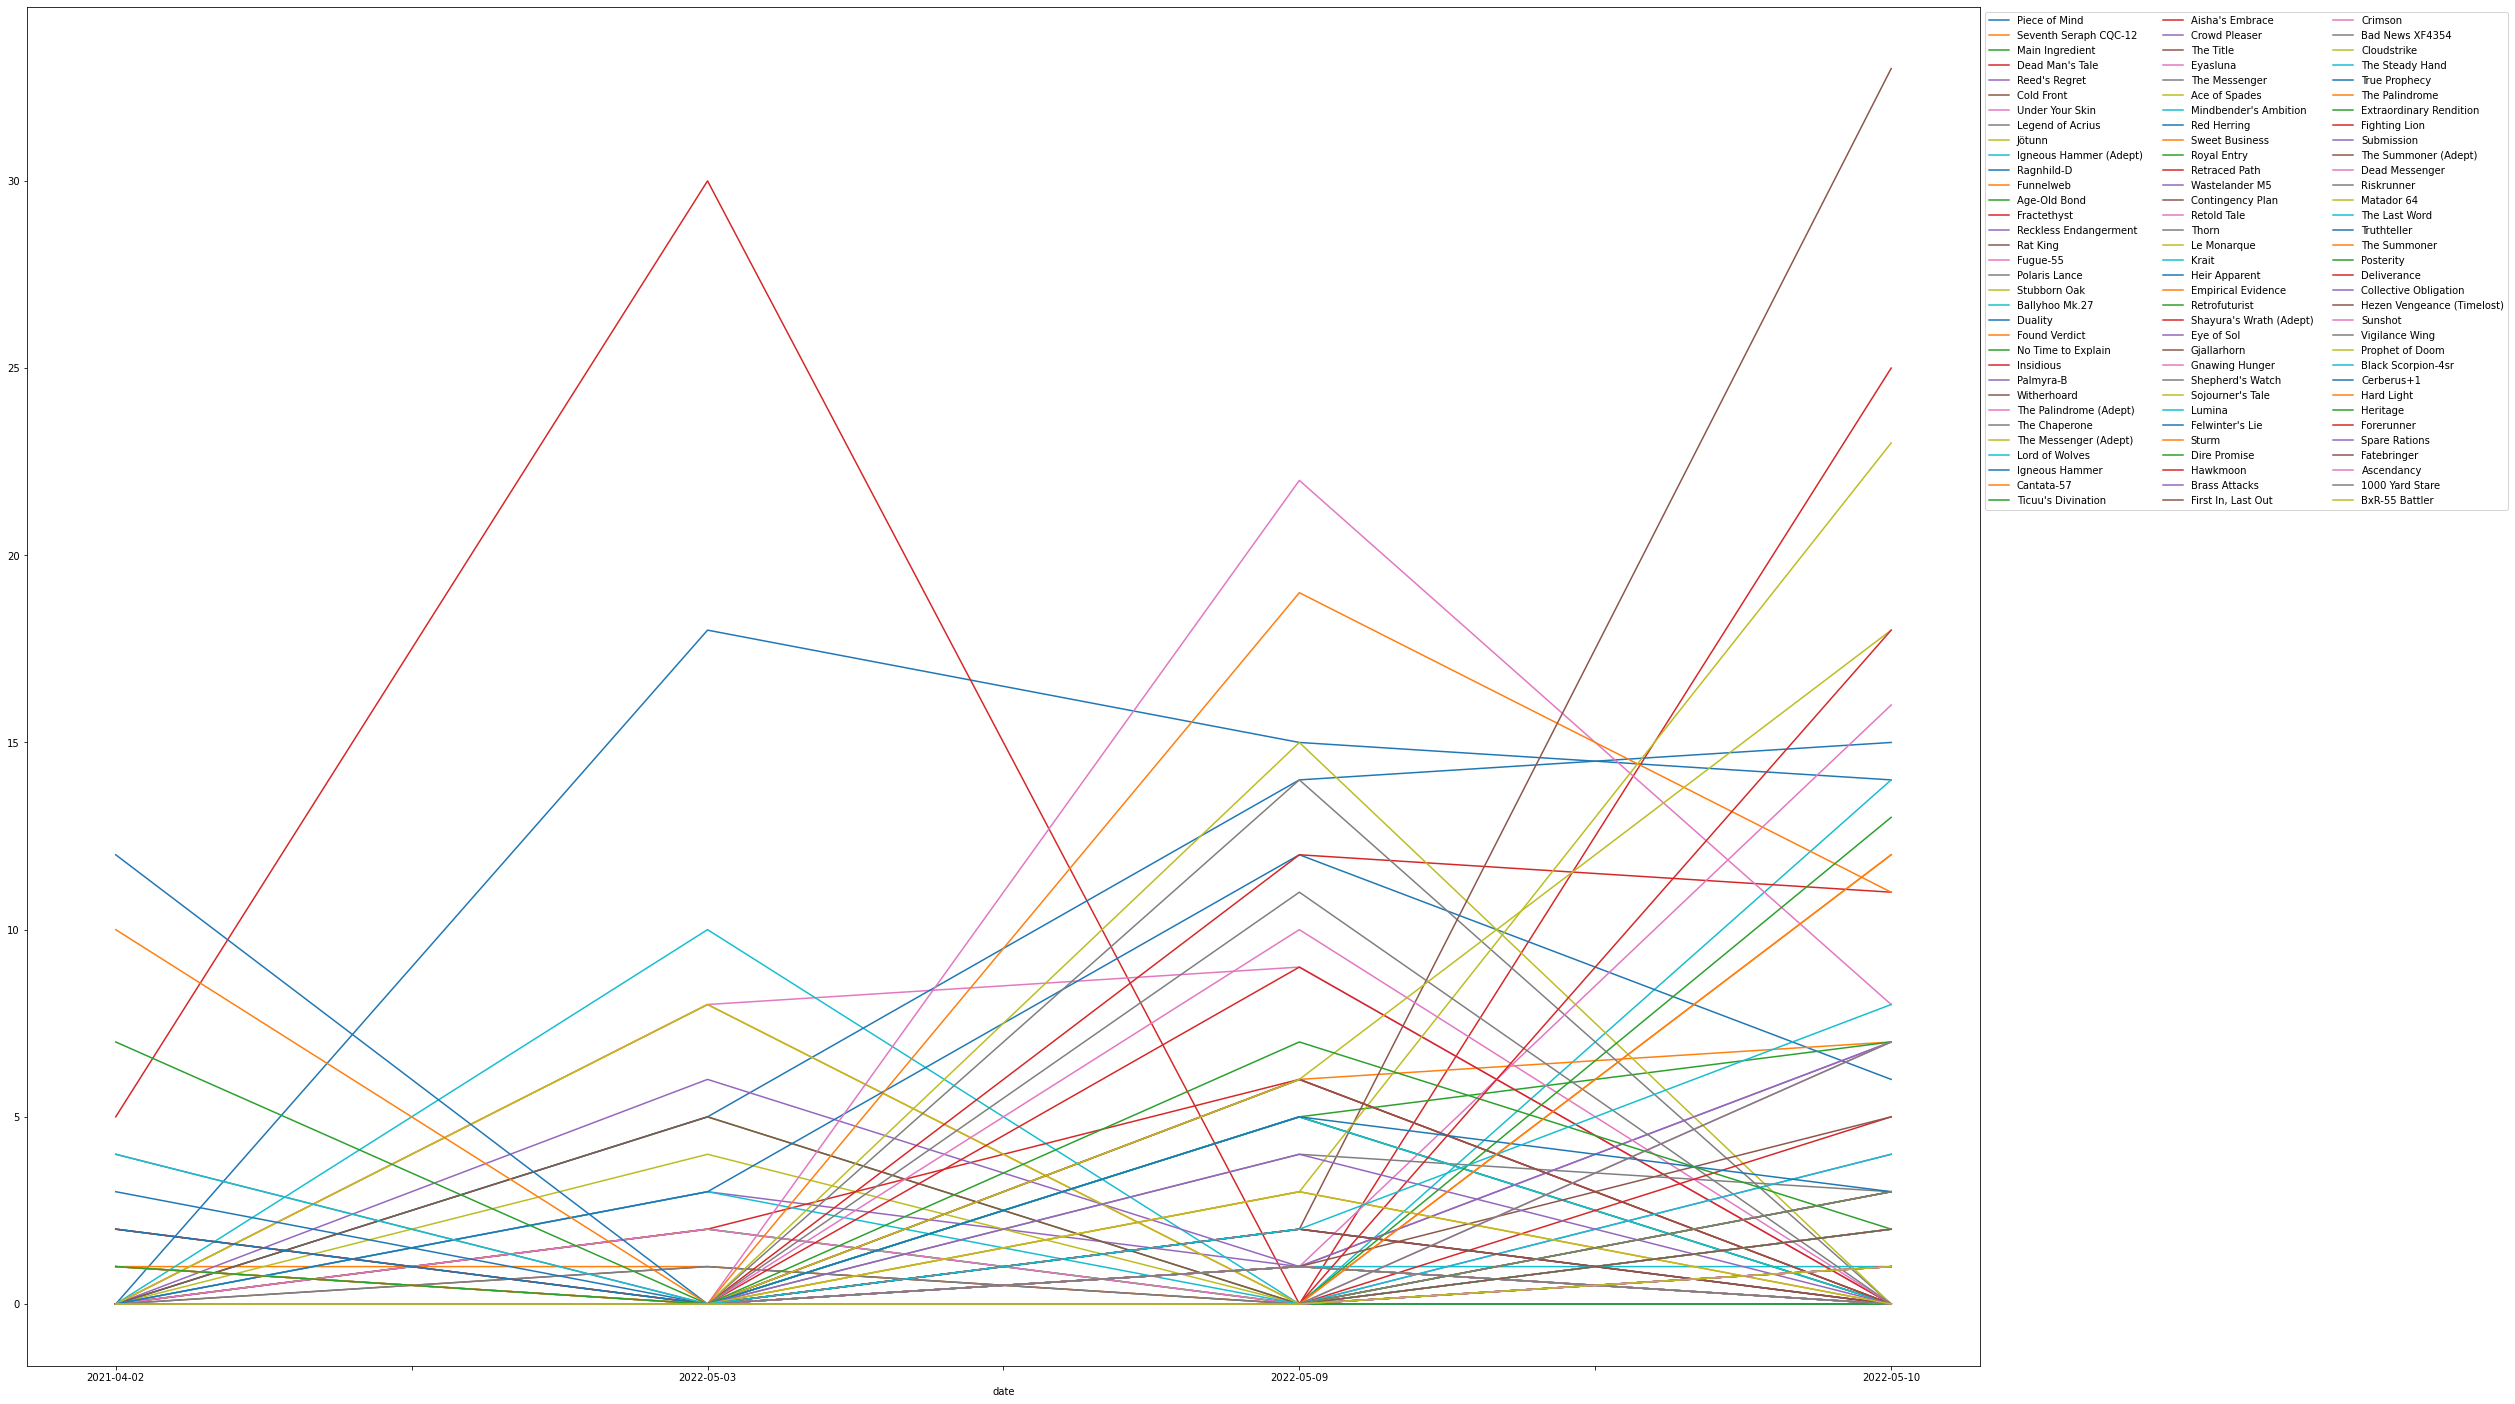

In [ ]:
ax3 = weaponNamesDFKills.plot.line(figsize=(35,25))
ax3.legend(bbox_to_anchor=(1.0, 1.0), ncol=3)
ax3.plot()

Because the above is hard to read, and features weapons that aren't related to the questions we are trying to answer, we need to do some filtering. The below code filters out any weapon that, over all data points gathered, had less than x (in this case 10) kills. Helps to focus on top option and weed out one-off weapons.

In [ ]:
print(weaponNamesDFKills)
weaponNamesDFKills30 = weaponNamesDFKills

print("\n\n\n")
print(weaponNamesDFKills30)
dropCols = []
cutThresh = 10

for i in range(len(weaponNamesDFKills30[weaponNamesDFKills30 > cutThresh].count())):
    if not(weaponNamesDFKills30[weaponNamesDFKills30 > cutThresh].count()[i] > 0):
        dropCols.append(weaponNamesDFKills30.columns[i])
weaponNamesDFKills30.drop(dropCols, axis=1, inplace=True)  

Plots the above graph, which produces a relatively uninterpretable graph that maps total kills by day. Some information can be gleaned from this, but ultimately it is essentially useless, especially as you look at weapon further down, even after filtering. It is, however, far more interpretable than the previous omega graph.

[]

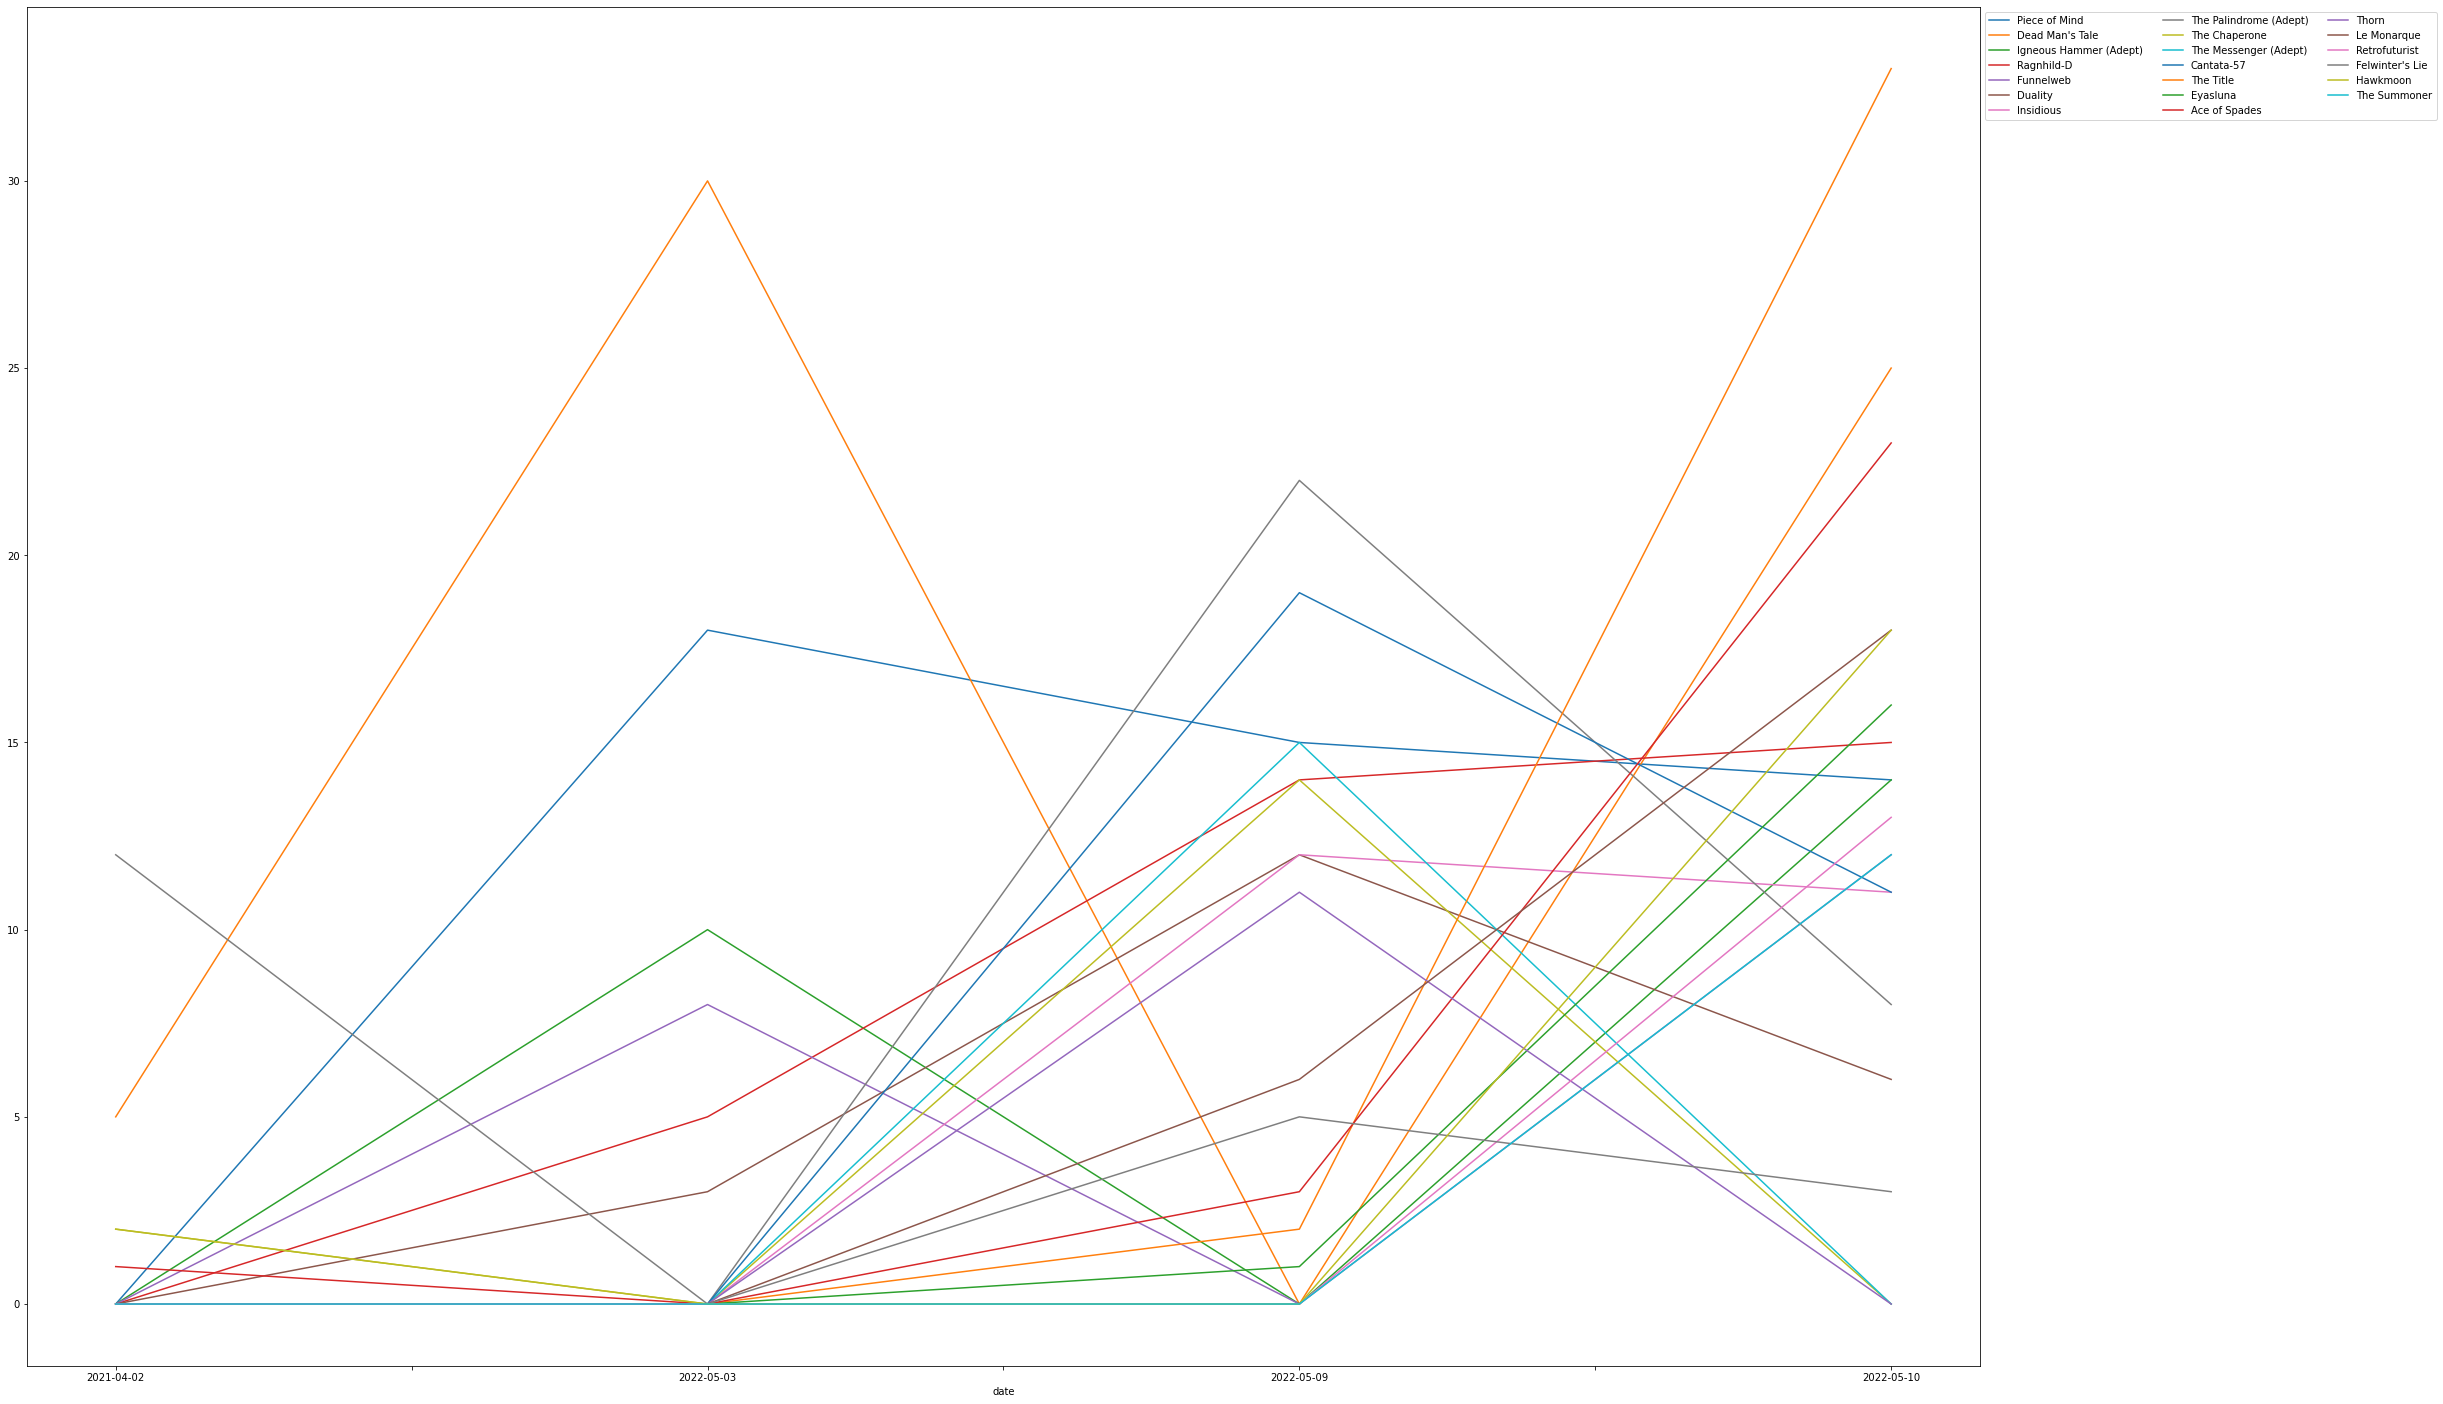

In [ ]:
ax = weaponNamesDFKills30.plot.line(figsize=(35,25))
ax.legend(bbox_to_anchor=(1.0, 1.0), ncol=3)
ax.plot()


This next further breaks down top options, this time taking into account the amount of days it was tracked for. It averages the number of kills over the number of days for an average kills per day, and then plots those items against each other. Here, we filter it such that it only keeps weapons that have an average kills per day greater than 5. This gets us a set of weapons that boast being used multiple days, which is a very important metric given the low player count we observe.

[]

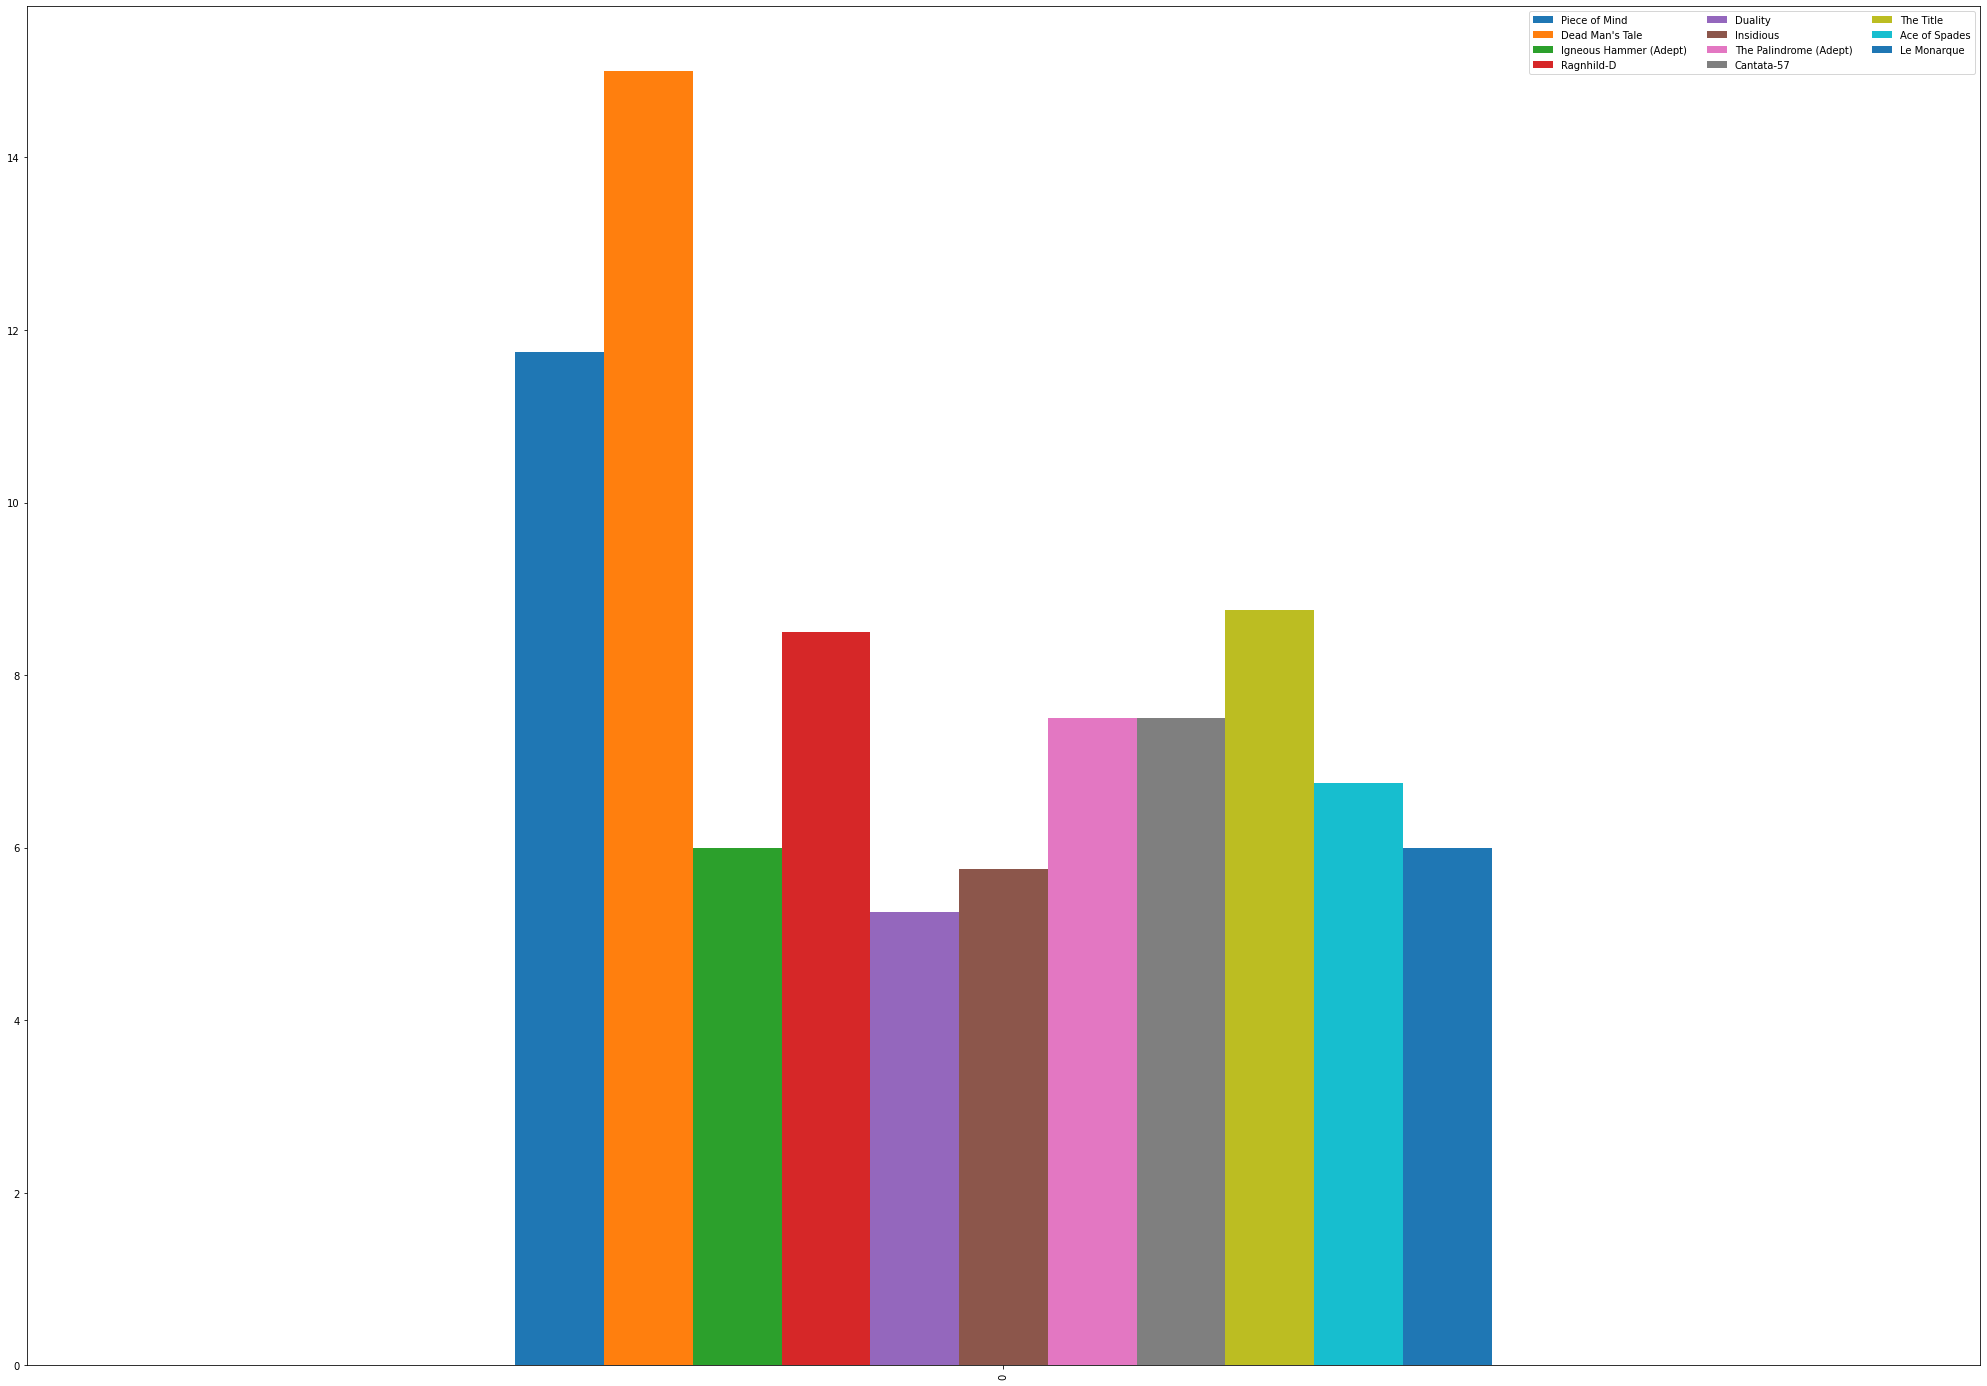

In [ ]:
weaponKPDDF = weaponNamesDFKills30
weaponKPDDF = pd.DataFrame()
for col in weaponNamesDFKills30:
    if weaponNamesDFKills30[str(col)].mean() > 5:
        toAppend = {str(col): [weaponNamesDFKills30[str(col)].mean()]}
        toAppendDF = pd.DataFrame(data=toAppend)
        weaponKPDDF = pd.concat([weaponKPDDF, toAppendDF], axis=1)
ax2 = weaponKPDDF.plot.bar(figsize=(35,25))
ax2.legend(bbox_to_anchor=(1.0, 1.0), ncol=3)
ax2.plot()

From my qualitative understanding of the game, all of these picks make sense. As was discussed at the end of the presentation, in order to truly answer the initially posed question we need to perform an analysis on videos made by the community discussing these weapons and their sentiment about them. This would reveal the influence of well-known people in the community and their thoughts. Additionally, we would need to run a program to generate a "strength" coefficient for a given change to a weapon. We can then map a predicted increase/decrease is usage based on that coefficient and compare it to actual results to test our theory. In order to get that predicted change, we would need to train it on known data and apply it to more recent data, kind of like a slightly altered version of Christopher's project. Also, if you want better graphs that might offer more data, mess with the number of games and iterations in the first cell, which will regenerate the data that the program uses. With a larger dataset you may also want to adjust the cutoffs for some of the filtering, as larger data sets means larger numbers